# Example LSTM for timeseries prediction

Here we build an LSTM predicting a simple sine curve. The goal is mostly to understand the input and output shapes and general architecture of an LSTM for time series prediciton.

In [5]:
import numpy as np
    
x = np.linspace(0, 967, 1000)
x = np.sin(x)
x[:10]

array([ 0.        ,  0.8237353 ,  0.93407392,  0.23545699, -0.66707768,
       -0.99188913, -0.45767412,  0.47290996,  0.99392995,  0.65415603])

In [6]:
x = x.reshape(100, 10)
x[:3]

array([[ 0.        ,  0.8237353 ,  0.93407392,  0.23545699, -0.66707768,
        -0.99188913, -0.45767412,  0.47290996,  0.99392995,  0.65415603],
       [-0.2521503 , -0.94008164, -0.81385444,  0.01721212,  0.83337211,
         0.92778945,  0.21869391, -0.67980168, -0.98955442, -0.44230268],
       [ 0.48800569,  0.9956763 ,  0.64104057, -0.26876891, -0.94581084,
        -0.80373245,  0.03441914,  0.84276201,  0.92123009,  0.20186604]])

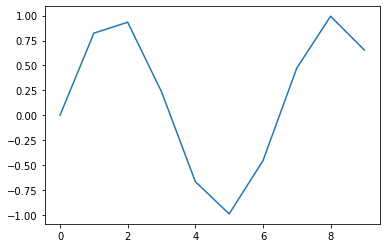

In [7]:
import matplotlib.pyplot as plt

plt.plot(x[0])

In [10]:
import torch

X = torch.Tensor(x)
y = X[:, -1].view(X.shape[0], 1)
X = X[:, :X.shape[1] - 1]

x[:3], X[:3], y[:3]

(array([[ 0.        ,  0.8237353 ,  0.93407392,  0.23545699, -0.66707768,
         -0.99188913, -0.45767412,  0.47290996,  0.99392995,  0.65415603],
        [-0.2521503 , -0.94008164, -0.81385444,  0.01721212,  0.83337211,
          0.92778945,  0.21869391, -0.67980168, -0.98955442, -0.44230268],
        [ 0.48800569,  0.9956763 ,  0.64104057, -0.26876891, -0.94581084,
         -0.80373245,  0.03441914,  0.84276201,  0.92123009,  0.20186604]]),
 tensor([[ 0.0000,  0.8237,  0.9341,  0.2355, -0.6671, -0.9919, -0.4577,  0.4729,
           0.9939],
         [-0.2522, -0.9401, -0.8139,  0.0172,  0.8334,  0.9278,  0.2187, -0.6798,
          -0.9896],
         [ 0.4880,  0.9957,  0.6410, -0.2688, -0.9458, -0.8037,  0.0344,  0.8428,
           0.9212]]),
 tensor([[ 0.6542],
         [-0.4423],
         [ 0.2019]]))

In [40]:
"predict y basec on X with LSTM"

from torch.nn import LSTM

lstm = LSTM(
    input_size=1,  # number of features per timestep
    hidden_size=2,
    batch_first=True,  # shape I'm used to: first the bartch size (# of samples), then the sequence of samples, then the features per timestep, see below
    num_layers=1
)

lstm

LSTM(1, 2, batch_first=True)

In [41]:
# batch_first = True: input must be of form (N, L, H), where N = batch_size, L = sequence_length,  H = input size (i.e. number of features)
X = X.reshape(X.shape[0], -1, 1)
X.shape, X[:3]

(torch.Size([100, 9, 1]),
 tensor([[[ 0.0000],
          [ 0.8237],
          [ 0.9341],
          [ 0.2355],
          [-0.6671],
          [-0.9919],
          [-0.4577],
          [ 0.4729],
          [ 0.9939]],
 
         [[-0.2522],
          [-0.9401],
          [-0.8139],
          [ 0.0172],
          [ 0.8334],
          [ 0.9278],
          [ 0.2187],
          [-0.6798],
          [-0.9896]],
 
         [[ 0.4880],
          [ 0.9957],
          [ 0.6410],
          [-0.2688],
          [-0.9458],
          [-0.8037],
          [ 0.0344],
          [ 0.8428],
          [ 0.9212]]]))

In [42]:
# output of LSTM 
output, (h, c) = lstm(X)

In [43]:
output.shape  # (N, L, H_out), L, N as above, H_out = hiddensize. 

torch.Size([100, 9, 2])

In [44]:
h.shape  #(num_layers, N, H_out)

torch.Size([1, 100, 2])

In [45]:
c.shape  # cell states, probably don't need

torch.Size([1, 100, 2])

In [209]:
import torch.nn as nn

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.count = 0
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layers, batch_first = True)
        self.output_layer = nn.Linear(hidden_size,1)
        self.linear_layer1 = nn.Linear(9, 1)

        
    def forward(self, input):
        output, (h, c) = self.lstm(input)
        output = self.output_layer(output).view(100, 9)  # removing LSTM'S extra dimensinos for next linear layer
        output = self.linear_layer1(output)
        return output
    
    def fit(self, X, y, n_epochs, learning_rate):
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(self.lstm.parameters(), lr=learning_rate) 
        
        for epoch in range(n_epochs):
            outputs = self.forward(X) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0

            if self.count == 0:
                display(outputs.shape, y.shape)
                self.count += 1
            # obtain the loss function
            loss = criterion(outputs, y)

            loss.backward() #calculates the loss of the loss function
            optimizer.step() #improve from loss, i.e backprop
            
            if epoch % 100 == 0:
                print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

In [210]:
MyLSTM(1, 2, 1).forward(X)[:3]

tensor([[0.1296],
        [0.1507],
        [0.1316]], grad_fn=<SliceBackward0>)

In [215]:
lstm = MyLSTM(
    input_size=1,
    hidden_size=2,
    num_layers=1
)

lstm.fit(X, y, n_epochs=6000, learning_rate=0.001)

torch.Size([100, 1])

torch.Size([100, 1])

Epoch: 0, loss: 0.50221
Epoch: 100, loss: 0.49026
Epoch: 200, loss: 0.48021
Epoch: 300, loss: 0.46961
Epoch: 400, loss: 0.45856
Epoch: 500, loss: 0.44377
Epoch: 600, loss: 0.42568
Epoch: 700, loss: 0.40899
Epoch: 800, loss: 0.39232
Epoch: 900, loss: 0.37676
Epoch: 1000, loss: 0.36203
Epoch: 1100, loss: 0.34731
Epoch: 1200, loss: 0.33274
Epoch: 1300, loss: 0.31470
Epoch: 1400, loss: 0.28244
Epoch: 1500, loss: 0.26274
Epoch: 1600, loss: 0.25147
Epoch: 1700, loss: 0.24205
Epoch: 1800, loss: 0.23375
Epoch: 1900, loss: 0.22606
Epoch: 2000, loss: 0.21838
Epoch: 2100, loss: 0.20941
Epoch: 2200, loss: 0.18808
Epoch: 2300, loss: 0.09304
Epoch: 2400, loss: 0.07067
Epoch: 2500, loss: 0.06569
Epoch: 2600, loss: 0.06162
Epoch: 2700, loss: 0.05780
Epoch: 2800, loss: 0.05469
Epoch: 2900, loss: 0.05212
Epoch: 3000, loss: 0.04992
Epoch: 3100, loss: 0.04801
Epoch: 3200, loss: 0.04635
Epoch: 3300, loss: 0.04489
Epoch: 3400, loss: 0.04359
Epoch: 3500, loss: 0.04245
Epoch: 3600, loss: 0.04142
Epoch: 3700, 

In [216]:
# mean absolute error on training set
np.abs((lstm.forward(X).detach().numpy() - y.detach().numpy())).mean()

0.14013287

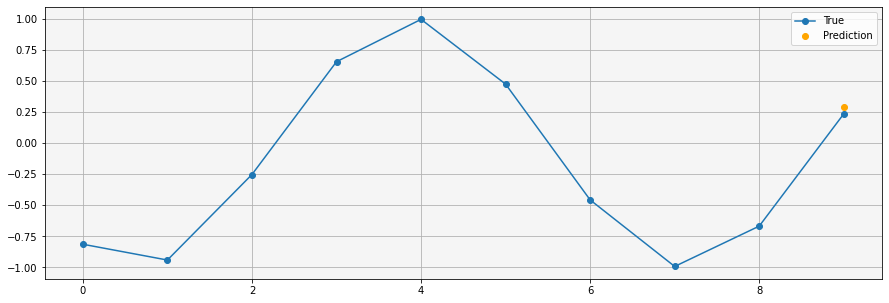

In [249]:
def plot_prediction(i):
    xi = X[i]
    preds = lstm.forward(X)
    pred = preds[i].item()
    xi, yi = xi.detach().numpy().reshape(-1), y[i].item()
    true = np.append(xi, yi)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(true, marker="o", label="True")
    ax.scatter([9], pred, color="orange", label="Prediction")
    ax.legend()
    ax.set_facecolor("whitesmoke")
    ax.grid()

plot_prediction(90)